In [0]:
import os
import tarfile
import fnmatch

import numpy as np
import pandas as pd
import nibabel as nib
from collections import Counter

from sklearn.preprocessing import normalize as sklearn_normalize
from skimage.morphology import binary_opening


from matplotlib import pyplot as plt


import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras

In [0]:
#PATH -> Set your dataset path
PATH_DATA = PATH + "Data/MSD/"

# Preprocessing

### Data loading

In [7]:
tasks_tar = [f for f in os.listdir(PATH_DATA) if fnmatch.fnmatch(f, "*.tar")]

for task in [tasks_tar[0]] : 
  print(f"+ Processing {task}")
  with tarfile.open(PATH_DATA + task, 'r') as tar:
      tar.extractall()

+ Processing Task02_Heart.tar


In [9]:
tasks_tar

['Task02_Heart.tar',
 'Task03_Liver.tar',
 'Task05_Prostate.tar',
 'Task06_Lung.tar',
 'Task07_Pancreas.tar',
 'Task04_Hippocampus.tar',
 'Task09_Spleen.tar',
 'Task10_Colon.tar',
 'Task08_HepaticVessel.tar',
 'Task01_BrainTumour.tar']

### Preprocessing pipeline

General data preprocessing pipeline class for all tasks.

In [0]:
class MedicalDatasetPipeline :
  def __init__(self, task) :
    """
    Init MedicalDatasetPipeline for one task
    """
    self.task           = task
    self.DIR            = "/content/"
    self.DIR_TRAIN      = "/imagesTr/"
    self.DIR_TEST       = "/imagesTs/"
    self.DIR_GT         = "/labelsTr/"
    self.DIR_GT_TEST    = "/labelsTs/"
    self.DATA_TRAIN_DIR = self.DIR + self.task + self.DIR_TRAIN
    self.DATA_GT_DIR    = self.DIR + self.task + self.DIR_GT
    self.DATA_TEST_DIR  = self.DIR + self.task + self.DIR_TEST
    self.DATA_PRED_DIR  = self.DIR + self.task + self.DIR_GT_TEST
    self.img_shape      = None

  def get_train_set(self) :
    """
    Load training file and groundtruth file
    """
    self.files          = [f for f in os.listdir(self.DATA_TRAIN_DIR) if fnmatch.fnmatch(f, "[!.]*.nii.gz")]
    self.files_gt       = [f for f in os.listdir(self.DATA_GT_DIR) if fnmatch.fnmatch(f, "[!.]*.nii.gz")]
    self.n_train_sample = len(self.files)
    self.n_gt_sample    = len(self.files_gt)
    self.train_set      = np.empty(self.n_train_sample, dtype=object)
    self.gt_set         = np.empty(self.n_gt_sample, dtype=object)

    for i in range(self.n_train_sample) :
      img = nib.load(self.DATA_TRAIN_DIR + self.files[i]).get_data()
      self.train_set[i] = img

    for i in range(self.n_gt_sample) :
      img = nib.load(self.DATA_GT_DIR + self.files[i]).get_data()
      self.gt_set[i] = img
    
    return self.train_set, self.gt_set

  def get_test_set(self) :
    """
    Load test file
    """    
    self.files_test     = [f for f in os.listdir(self.DATA_TEST_DIR) if fnmatch.fnmatch(f, "[!.]*.nii.gz")]
    self.n_test_sample  = len(self.files_test)
    self.test_set       = np.empty(self.n_test_sample, dtype=object)

    for i in range(self.n_test_sample) : 
      img = nib.load(self.DATA_TEST_DIR + self.files_test[i]).get_data()
      self.test_set[i] = img

    return self.test_set

  def display_train_set(self, nb_patient=10, slice_index=30) :
    fig = plt.figure(figsize= (7, 50), dpi = 90)

    k = 0
    for i in range(nb_patient) :

        plt.subplot(10, 2, k + 1)
        plt.imshow(self.train_set[i][:,:,slice_index])
        plt.subplots_adjust(wspace = 0)
        plt.title("original")
        plt.axis('off')

        k += 1 
        
        mask = self.gt_set[i][:, :, slice_index] == 1
        tmp = self.train_set[i][:, :, slice_index]
        tmp[mask] = 2000

        plt.subplot(10, 2, k + 1)
        plt.imshow(tmp)
        plt.title("GT")
        plt.subplots_adjust(wspace = 0)
        plt.axis('off')

        k += 1

  def get_max_occurence_value(self, x) :
    inv_map = {v: k for k, v in Counter(x).items()}
    return inv_map[max(inv_map.keys())]

  def get_img_shape(self) :
    size_list_x = []
    size_list_y = []
    
    for patient_data in self.train_set :
      size_list_x.append(patient_data.shape[0])
      size_list_y.append(patient_data.shape[1])
    
    self.img_shape = (self.get_max_occurence_value(size_list_x),
                      self.get_max_occurence_value(size_list_y))
    return self.img_shape

  #def resize(self, x, target_size=self.img_shape) :
  #  return np.resize(x, target_size)

  def normalize(self, x) :
    for i in range(x.shape[0]):
      x[i] = sklearn_normalize(x[i], norm='max', copy=True, return_norm=False)
    return x

  def get_x_train(self) :
    """
    Compute x_train from training set
    """
    self.x_train_len = 0
    for patient_data in self.train_set :
      self.x_train_len += patient_data.shape[2]

    """
    Get image shape, choosing the most represented one from training set
    """   
    if self.img_shape is None :
      self.get_img_shape()
    
    self.x_train = [] #(self.x_train_len, dtype=object)

    i = 0
    for patient_data in self.train_set :
      for j in range(patient_data.shape[2]) :
        if patient_data.T[j].shape == self.img_shape :
          self.x_train.append(patient_data.T[j])
        else :
          """
          Resize slice if not the right shape
          """
          self.x_train.append(np.resize(patient_data.T[j], self.img_shape))

    self.x_train = np.array(self.x_train)
    
    """
    Normalize
    """
    self.x_train = self.normalize(self.x_train)

    return self.x_train

  def get_y_train(self) :
    """
    Compute y_train from groundtruth set
    """
    self.y_train_len = 0
    for patient_data in self.gt_set :
      self.y_train_len += patient_data.shape[2]

    """
    Get image shape, choosing the most represented one from training set
    """   
    if self.img_shape is None :
      self.get_img_shape()
    
    self.y_train = []

    i = 0
    for patient_data in self.gt_set :
      for j in range(patient_data.shape[2]) :
        if patient_data.T[j].shape == self.img_shape :
          self.y_train.append(patient_data.T[j])
        else :
          """
          Resize slice if not the right shape
          """
          self.y_train.append(np.resize(patient_data.T[j], self.img_shape))

    self.y_train = np.array(self.y_train)
    
    """
    Normalize
    """
    self.y_train = self.normalize(self.y_train)

    return self.y_train

  def get_x_test(self) :
    """
    Compute x_test from test set
    """
    self.x_test_len = 0
    for patient_data in self.test_set :
      self.x_test_len += patient_data.shape[2]

    """
    Get image shape, choosing the most represented one from training set
    """   
    if self.img_shape is None :
      self.get_img_shape()
    
    self.x_test = []

    i = 0
    for patient_data in self.test_set :
      for j in range(patient_data.shape[2]) :
        if patient_data.T[j].shape == self.img_shape :
          self.x_test.append(patient_data.T[j])
        else :
          """
          Resize slice if not the right shape
          """
          self.x_test.append(np.resize(patient_data.T[j], self.img_shape))

    self.x_test = np.array(self.x_test)
    
    """
    Normalize
    """
    self.x_test = self.normalize(self.x_test)

    return self.x_test

  def postprocess(self, x, treshold = 0.5) : 
    for i in range(x.shape[0]):
         x[x >= treshold] = 1
         x[x < treshold] = 0
         x[i] = binary_opening(x[i , :, :] == 1)
    return x

  def save_predictions(self, y_pred) :
    """
    Save predictions
    """
    i = 0
    k = 0
    for patient_data in self.test_set :
      y_pred_resize = []
      for j in range(patient_data.shape[2]) :
        if patient_data.T[j].shape == self.img_shape :
          y_pred_resize.append(y_pred[i])
        else :
          """
          Resize slice if not the right shape
          """
          y_pred_resize.append(np.resize(y_pred[i], patient_data.T[j].shape))
        i+=1
      y_pred_resize = np.array(y_pred_resize)
      tmp = y_pred_resize.astype(np.uint8)
      img = nib.Nifti1Image(tmp, np.eye(4))
      nib.save(img, self.DIR_GT_TEST + self.files_test[k])
      k+=1

    



### Example - Preprocess Left Atrium Segmentation Data

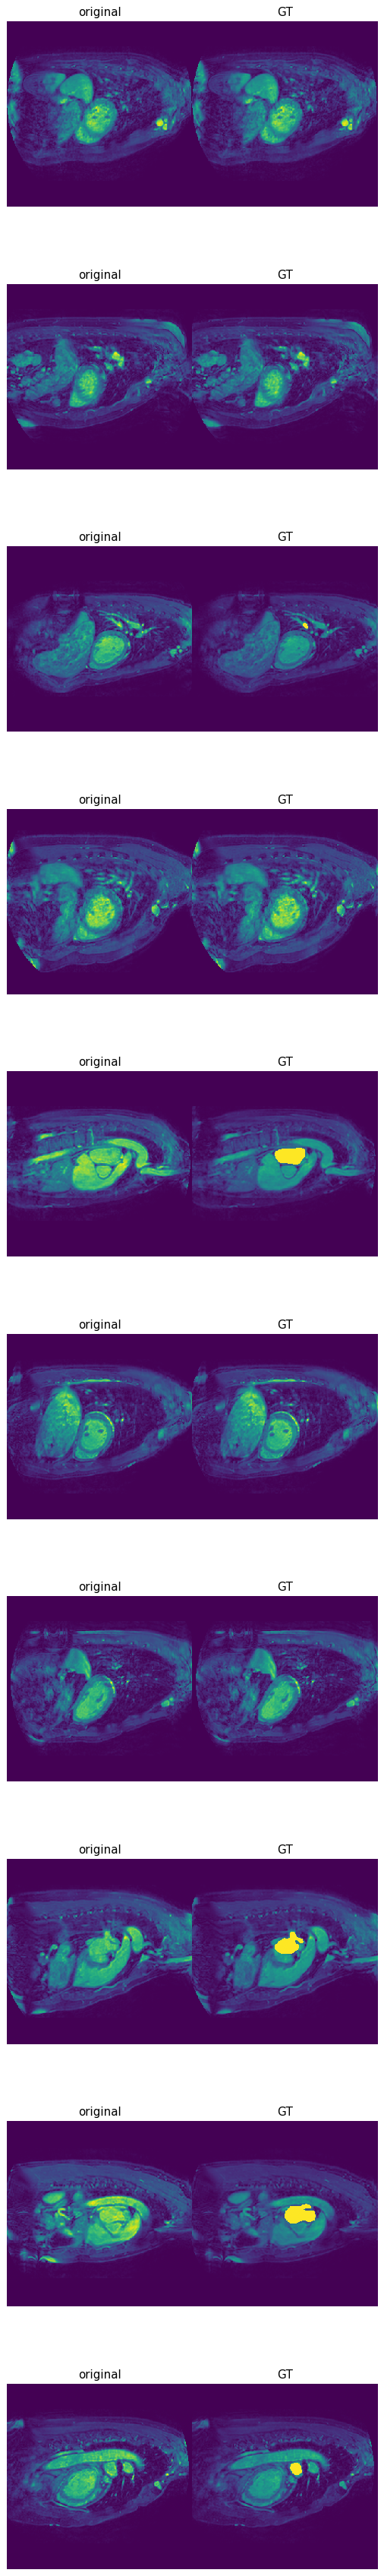

In [11]:
pipeline = MedicalDatasetPipeline("Task02_Heart")
pipeline.get_train_set()
pipeline.get_test_set()
pipeline.display_train_set()

In [12]:
x_train, y_train, x_test = pipeline.get_x_train(), pipeline.get_y_train(), pipeline.get_x_test()
x_train.shape, y_train.shape, x_test.shape

((2271, 320, 320), (2271, 320, 320), (1297, 320, 320))

# Model - Unet

Implementation based on U-Net: Convolutional Networks for Biomedical
Image Segmentation https://arxiv.org/pdf/1505.04597.pdf

In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

### Unbalanced Dataset Handling

In [0]:
from sklearn.utils.class_weight import compute_class_weight

class_wights = compute_class_weight('balanced', [0, 1], y_train.flatten())

In [0]:
class_wights, print('array([  0.50239596, 104.84212251])')

array([  0.50239596, 104.84212251])


(array([  0.50201846, 124.35650765]), None)

### Create Custom Metrics/Loss - Dice coeff loss

In [16]:
from keras import backend as K

def binarise(y_pred) : 
  threshold, upper, lower = 0.5, 1, 0
  y_pred[y_pred >= threshold] = 1.
  y_pred[y_pred < threshold] = 0.
  return y_pred

def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice


def dice_coef_loss(y_true, y_pred):
    return -tf.math.log( dice_coef(y_true, y_pred))

Using TensorFlow backend.


In [0]:
input_img = Input((pipeline.img_shape[0], pipeline.img_shape[1], 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss=dice_coef_loss, metrics=[dice_coef])
model.summary()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 320, 320, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 320, 320, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 320, 320, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 320, 320, 16) 0           batch_normalization[0][0]        
_____________

In [0]:
x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2] ,1))

(2271, 320, 320)

# Training Model

In [0]:
from datetime import datetime

epoch = 50
batch_size = 32

logdir = PATH + "Model/logs/unet-batch_size-{}-epochs-{}-loss-{}.h5".format(batch_size, epoch, 'dice_coef_loss') + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

history = model.fit(x = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2] ,1)),
                    y = y_train.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2] ,1)),
                    batch_size=batch_size, epochs = epoch,
                    validation_split=0.2,
                    class_weight=class_wights,
                    callbacks=[
                               tensorboard_callback,
                               ModelCheckpoint(filepath=PATH + "Model/unet-pipeline-batch_size-{}-epochs-{}-loss-{}.h5".format(batch_size, epoch, 'dice_coef_loss'), verbose=1, save_best_only=True, save_weights_only=False)                            
])

Train on 1816 samples, validate on 455 samples
Epoch 1/50
1792/1816 [============================>.] - ETA: 0s - loss: 1.2608 - dice_coef: 0.2884
Epoch 00001: val_loss improved from inf to 2.01535, saving model to /content/drive/My Drive/Edwin_project/Model/unet-pipeline-batch_size-32-epochs-50-loss-dice_coef_loss.h5
1816/1816 [==============================] - 25s 14ms/sample - loss: 1.2583 - dice_coef: 0.2893 - val_loss: 2.0153 - val_dice_coef: 0.1428
Epoch 2/50
1792/1816 [============================>.] - ETA: 0s - loss: 1.0615 - dice_coef: 0.3503
Epoch 00002: val_loss improved from 2.01535 to 1.87282, saving model to /content/drive/My Drive/Edwin_project/Model/unet-pipeline-batch_size-32-epochs-50-loss-dice_coef_loss.h5
1816/1816 [==============================] - 23s 13ms/sample - loss: 1.0591 - dice_coef: 0.3514 - val_loss: 1.8728 - val_dice_coef: 0.1629
Epoch 3/50
1792/1816 [============================>.] - ETA: 0s - loss: 0.9514 - dice_coef: 0.3898
Epoch 00003: val_loss improv

# Training Metrics Result

dict_keys(['loss', 'dice_coef', 'val_loss', 'val_dice_coef'])


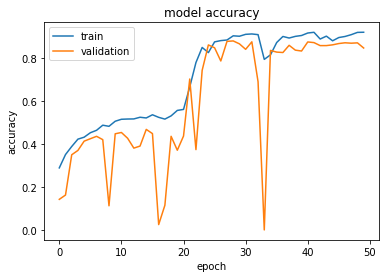

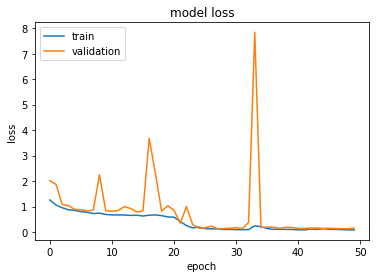

In [0]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Load Model and Predict on Test Data

In [17]:
model_loaded = load_model(PATH + 'Model/unet-pipeline-batch_size-16-epochs-50-loss-dice_coef_loss.h5', custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef})

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
y_test = model_loaded.predict(x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2] ,1)))

In [23]:
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2]))
y_test.shape

(1297, 320, 320)

In [26]:
y_test_post_process = pipeline.postprocess(y_test)
y_test_post_process.shape

(1297, 320, 320)

In [0]:
def display_test_set(x_test, y_test, nb_patient=10, slice_index=30) :
  fig = plt.figure(figsize= (7, 50), dpi = 90)

  k = 0
  for i in range(nb_patient) :

      plt.subplot(10, 2, k + 1)
      plt.imshow(x_test[i])#[:,:,slice_index])
      plt.subplots_adjust(wspace = 0)
      plt.title("original")
      plt.axis('off')

      k += 1 
      
      mask = y_test[i] == 1#[:, :, slice_index] == 1
      tmp = x_test[i]#[:, :, slice_index]
      tmp[mask] = 2000

      plt.subplot(10, 2, k + 1)
      plt.imshow(tmp)
      plt.title("PREDICTION")
      plt.subplots_adjust(wspace = 0)
      plt.axis('off')

      k += 1
display_test_set(x_test, y_test_post_process)

In [0]:
fig = plt.figure(figsize= (7, 50), dpi = 210)

n_slice = 40

print(n_sample)
k = 0
for i in range(50) : 
  #if np.any(y_test[i, :, :] == 2) : 
      tmp = x_test[i + 500, :, :]
      plt.subplot(50, 2, k + 1)
      plt.imshow(tmp)
      plt.axis("off")

      k += 1

      tmp = y_test[i + 500, :, :]
      
      plt.subplot(50, 2, k + 1)
      plt.imshow(tmp.reshape((320, 320)))
      plt.axis("off")

      k+= 1

  #print("DONE")

Output hidden; open in https://colab.research.google.com to view.